In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import List
from gpytorch.kernels import RBFKernel
from gpytorch.priors import NormalPrior
from mobius import Planner, SequenceGA
from mobius import ProteinEmbedding
from mobius import GPLLModel, ExpectedImprovement

## Initialize GFP oracle

Source : 
- Kirjner, A., 2023, https://doi.org/10.48550/arXiv.2307.00494
- Lee et al., 2024, https://doi.org/10.48550/arXiv.2405.18986

In [3]:
ALPHABET = list('ARNDCQEGHILKMFPSTWYV')
IDXTOAA = {i: ALPHABET[i] for i in range(20)}
AATOIDX = {v: k for k, v in IDXTOAA.items()}

class MaskedConv1d(nn.Conv1d):
    """ A masked 1-dimensional convolution layer.

    Takes the same arguments as torch.nn.Conv1D, except that the padding is set automatically.

         Shape:
            Input: (N, L, in_channels)
            input_mask: (N, L, 1), optional
            Output: (N, L, out_channels)
    """

    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: int, stride: int=1, dilation: int=1, groups: int=1,
                 bias: bool=True):
        """
        :param in_channels: input channels
        :param out_channels: output channels
        :param kernel_size: the kernel width
        :param stride: filter shift
        :param dilation: dilation factor
        :param groups: perform depth-wise convolutions
        :param bias: adds learnable bias to output
        """
        padding = dilation * (kernel_size - 1) // 2
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation,
                                           groups=groups, bias=bias, padding=padding)

    def forward(self, x, input_mask=None):
        if input_mask is not None:
            x = x * input_mask
        return super().forward(x.transpose(1, 2)).transpose(1, 2)


class LengthMaxPool1D(nn.Module):
    def __init__(self, in_dim, out_dim, linear=False, activation='relu'):
        super().__init__()
        self.linear = linear
        if self.linear:
            self.layer = nn.Linear(in_dim, out_dim)

        if activation == 'swish':
            self.act_fn = lambda x: x * torch.sigmoid(100.0*x)
        elif activation == 'softplus':
            self.act_fn = nn.Softplus()
        elif activation == 'sigmoid':
            self.act_fn = nn.Sigmoid()
        elif activation == 'leakyrelu':
            self.act_fn = nn.LeakyReLU()
        elif activation == 'relu':
            self.act_fn = lambda x: F.relu(x)
        else:
            raise NotImplementedError

    def forward(self, x):
        if self.linear:
            x = self.act_fn(self.layer(x))
        x = torch.max(x, dim=1)[0]
        return x


class BaseCNN(nn.Module):
    def __init__(
            self,
            n_tokens: int = 20,
            kernel_size: int = 5 ,
            input_size: int = 256,
            dropout: float = 0.0,
            make_one_hot=True,
            activation: str = 'relu',
            linear: bool=True,
            **kwargs):
        super(BaseCNN, self).__init__()
        self.encoder = nn.Conv1d(n_tokens, input_size, kernel_size=kernel_size)
        self.embedding = LengthMaxPool1D(
            linear=linear,
            in_dim=input_size,
            out_dim=input_size*2,
            activation=activation,
        )
        self.decoder = nn.Linear(input_size*2, 1)
        self.n_tokens = n_tokens
        self.dropout = nn.Dropout(dropout) # TODO: actually add this to model
        self.input_size = input_size
        self._make_one_hot = make_one_hot
    
    def get_embed(self, x):
        #onehotize
        if self._make_one_hot:
            x = F.one_hot(x.long(), num_classes=self.n_tokens)
        x = x.permute(0, 2, 1).float()
        # encoder
        x = self.encoder(x).permute(0, 2, 1)
        x = self.dropout(x)
        # embed
        x = self.embedding(x)
        return x

    def forward(self, x, get_embed=False):
        #onehotize
        if self._make_one_hot:
            x = F.one_hot(x.long(), num_classes=self.n_tokens)
        x = x.permute(0, 2, 1).float()
        # encoder
        x = self.encoder(x).permute(0, 2, 1)
        x = self.dropout(x)
        # embed
        x = self.embedding(x)
        # decoder
        output = self.decoder(x).squeeze(1)
        if get_embed:
            return x, output
        return output


def seq_to_one_hot(seq):
    return F.one_hot(torch.tensor([AATOIDX[aa] for aa in list(seq)]), 20)


class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __getitem__(self, idx):
        return seq_to_one_hot(self.sequences[idx])
    
    def __len__(self):
        return len(self.sequences)


class InSilicoLandscape:
    def __init__(self, checkpoint_filename, device=None):

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.device = device
        oracle = BaseCNN(make_one_hot=False)
        oracle_ckpt = torch.load(checkpoint_filename, map_location=self.device)
        if "state_dict" in oracle_ckpt.keys():
            oracle_ckpt = oracle_ckpt["state_dict"]
        oracle.load_state_dict({k.replace('predictor.',''):v for k,v in oracle_ckpt.items()})
        oracle.eval()

        self.oracle = oracle.to(self.device)
        
    def evaluate(self, sequences, starting_sequences, topk):
        scores = self.get_fitness(sequences)
        indices = np.argsort(scores)[::-1][:topk]
        sequences, targets = sequences[indices], scores[indices]
        fitness = np.median(targets)
        
        distances = []
        for s1, s2 in itertools.combinations(sequences, 2):
            distances.append(distance(s1, s2))
        diversity = np.median(distances)
        
        distances = []
        for j in sequences:
            dist_j = []
            for i in starting_sequences:
                dist_j.append(distance(i,j))
            distances.append(min(dist_j))
        novelty = np.median(distances)

        return scores, fitness, diversity, novelty
    
    def normalize_target(self, target):
        return (target - self.min_fitness)/(self.max_fitness - self.min_fitness)

    def get_fitness(self, sequences: List[str]):
        dset = SequenceDataset(sequences)
        dloader = DataLoader(dset, batch_size=128)
        scores = []

        for data in dloader:
            data = data.to(self.device)

            with torch.no_grad():
                score = self.oracle(data).detach().cpu().numpy().astype(float).reshape(-1)
            
            scores.append(score)

        return np.concatenate(scores)

In [4]:
landscape = InSilicoLandscape('oracle_GFP.ckpt')
gfp_data = pd.read_csv('ground_truth_gfp.csv')

vmin = gfp_data['score'].min()
vmax = gfp_data['score'].max()

In [5]:
y_pred = landscape.get_fitness(gfp_data['sequence'].values)

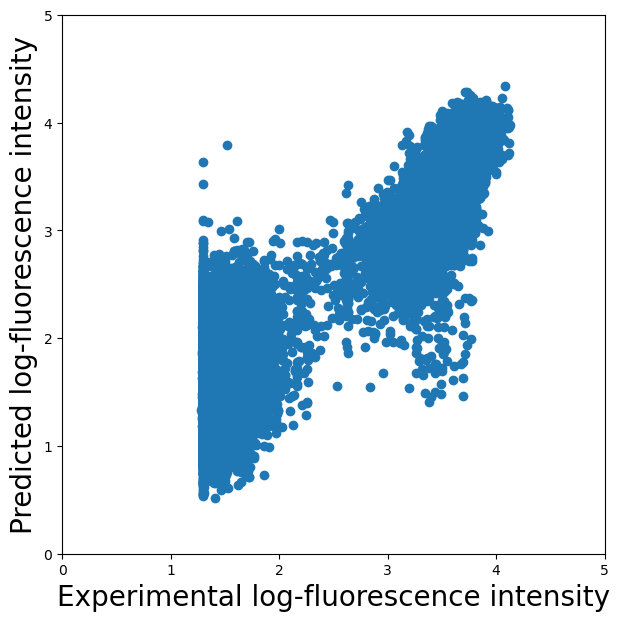

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(gfp_data['score'].values, y_pred)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

ax.set_ylabel('Predicted log-fluorescence intensity', fontsize=20)
ax.set_xlabel('Experimental log-fluorescence intensity', fontsize=20)

plt.show()

In [7]:
# Generate hard dataset, take sequence in 10th-30th percentiles
q10 = np.percentile(gfp_data['score'], 10)
q30 = np.percentile(gfp_data['score'], 30)
print(f'10th percentile: {q10:.3f}')
print(f'30th percentile: {q30:.3f}')

hard = gfp_data[(gfp_data['score'] >= q10) & (gfp_data['score'] <= q30)].copy()
hard.to_csv('ground_truth_gfp_hard.csv', index=False)
print(f'Number of sequences: {len(hard)}')

10th percentile: 1.301
30th percentile: 1.561
Number of sequences: 11349


## Run Bayesian Optimization

In [8]:
# Load protein language model
plm = ProteinEmbedding(pretrained_model_name='esm1b_t33_650M_UR50S', embedding_type='avg')

In [9]:
yaml_content = """
    design:
      monomers:
        default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
      biopolymers:
        - name: PEPTIDE1
          starting_residue: 1
          length: 237
          positions:
            1-237: default
    """
    
with open('design_protocol_gfp.yaml', 'w') as f:
    f.write(yaml_content)

In [10]:
# Load surrogate model
gpmodel = GPLLModel(kernel=RBFKernel(), pretrained_model=plm, noise_prior=NormalPrior(0, 1))
ei = ExpectedImprovement(gpmodel, maximize=True)
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='design_protocol_gfp.yaml')
ps = Planner(ei, optimizer)

In [11]:
# Take the 128 worst sequences in terms of log-fluorescence intensity
hard = hard.sort_values(by='score')
seed_library = hard['sequence'].values[:128]
scores_seed_library = hard['score'].values[:128]

In [12]:
sequences = seed_library.copy()
scores = scores_seed_library.copy()
        
# Store data for later analysis
data = [(0, p, s) for p, s in zip(sequences, scores)]
        
for i in range(5):
    suggested_sequences, _ = ps.recommand(sequences, scores.reshape(-1, 1), batch_size=128)
    scores_suggested_sequences = landscape.get_fitness(suggested_sequences)
        
    sequences = np.concatenate([sequences, suggested_sequences])
    scores = np.concatenate((scores, scores_suggested_sequences), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_sequences, scores_suggested_sequences)])
        
    best_seq = sequences[np.argmax(scores)]
    best_score = np.max(scores)
    min_score = np.min(scores_suggested_sequences)
    mean_score = np.mean(scores_suggested_sequences)
    normalized_best_score = (best_score - vmin) / (vmax - vmin)
    print(f'Best peptide found so far: {best_seq} / {best_score:.3f} ({normalized_best_score:.3f} min: {min_score:.3f}, mean: {mean_score:.3f})')
    print('')
    
    df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))
    df.to_csv('results_gfp_hard.csv', index=False)


Fitting GPLLM model (cuda): 24step [02:43,  6.82s/step, loss=-3.68]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.0000000000000E+00 |  0.0000000000000E+00 | SKGEELFTGVVPIPVELDGDVNGHKFSVSGEGEGDATYGK
     2 |      500 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     3 |     1000 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     4 |     1500 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     5 |     2000 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     6 |     2500 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     7 |     3000 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     8 |     3500 | -3.9894297741789E-03 | -3.9894297741789E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     9 |     4000 | -3.9894297741789E

Fitting GPLLM model (cuda): 24step [05:45, 14.41s/step, loss=0.627]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  5.62954040155594981 |  3.27031368017196655 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     2 |      500 | -1.9999700736812E-08 | -5.5369259598356E-06 | QKYQNGMVIDHPNPAWFDHDWYQARPELDGEHEANDEKGM
     3 |     1000 | -4.6030212019658E-08 | -5.6667282538800E-06 | QKYQNGMVIDHPNPAWFDHDWYQARPELDGEHEANDEKGM
     4 |     1500 | -8.6483517498568E-08 | -6.1430698559290E-06 | QKYQNGMVIDHPNPAWFDHDWYQARPELDGEHEANDEKGM
     5 |     2000 | -1.6612445040283E-07 | -7.2716196902583E-06 | QKYQNGMRPPRRARVELDGDVNGHKFSVPGWIHQKSAETA
     6 |     2500 | -3.0010962489830E-07 | -1.0644720683021E-05 | NMGAHLFAVQVWMLVDVDVMTNIHKQHMLYVQEGTQPNCV
     7 |     3000 | -8.0433825940620E-07 | -1.1333890638732E-04 | KKWEPLLTLFEPQPVELDCCDRHTASTCPGWIHQKSAETA
     8 |     3500 | -1.5458745854616E-06 | -1.1333890638732E-04 | KKWEPLLTLFEPQPVELDCCDRHTASTCPGWIHQKSAETA
     9 |     4000 | -3.4175579411673E

Fitting GPLLM model (cuda): 44step [18:04, 24.66s/step, loss=0.41] 


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  5.87811433123323912 |  3.27031368017196655 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     2 |      500 | -4.9261991907388E-12 | -9.0947816718652E-11 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     3 |     1000 | -1.0450562308166E-11 | -1.3526250920797E-10 | SMGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGK
     4 |     1500 | -2.1481587148553E-11 | -2.7072026521863E-10 | SKGEELFTGVVPILLELDGDVNGHKFSVSGEGEGDATYGK
     5 |     2000 | -3.7972849996423E-11 | -3.1808057906670E-10 | SKGEELFTGVVPILLELDGDVNGHKFSVSGEGEGDATYGK
     6 |     2500 | -6.1401339963177E-11 | -3.6078469536196E-10 | SKGEGLFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     7 |     3000 | -9.9522918231846E-11 | -6.3530891540495E-10 | SKGEGLFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     8 |     3500 | -1.4428759304417E-10 | -6.6242389867381E-10 | SKGEGLFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     9 |     4000 | -1.9867245186635E

Fitting GPLLM model (cuda): 32step [15:48, 29.63s/step, loss=0.0461]


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  5.96820296372677106 |  3.28839838504791260 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     2 |      500 | -7.7428853668595E-06 | -3.8359249473478E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     3 |     1000 | -1.3329572202983E-05 | -3.8359249473478E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     4 |     1500 | -1.3447108876448E-05 | -3.8359249473478E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     5 |     2000 | -1.5221034173739E-05 | -3.8359249473478E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     6 |     2500 | -2.7352062593468E-05 | -4.6028703058771E-03 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     7 |     3000 | -6.9146131688291E-05 | -4.7543435815650E-03 | SRGVELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     8 |     3500 | -1.4505828542591E-04 | -1.2822873707470E-02 | SKGEELFSGVVPILVELDGDVNGHKFSVSGEGEGDATYGK
     9 |     4000 | -3.1539305085471E

Fitting GPLLM model (cuda): 14step [10:10, 43.62s/step, loss=-0.101] 


n_gen  |  n_eval  |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  5.97728856040104439 |  3.51735508441925049 | SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGK


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.20 GiB. GPU 

/scratch/eberha0001/slurm-job.901971/ipykernel_1229908/1659103222.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axarr.legend(loc='upper right', fontsize=15, frameon=False)


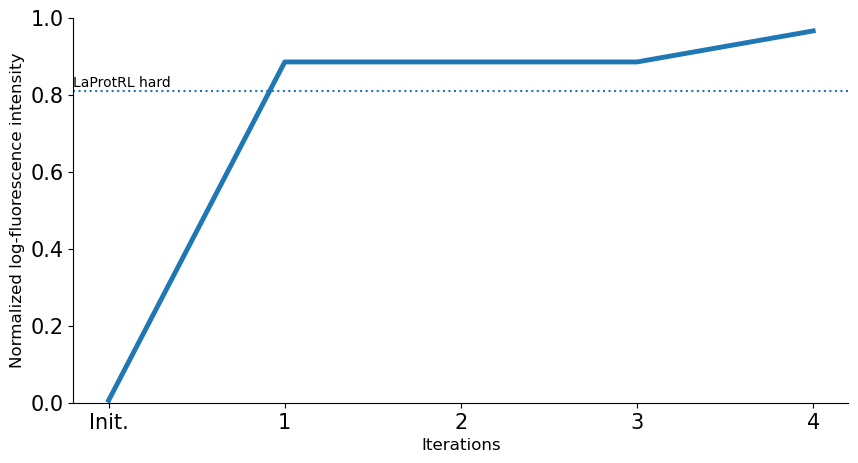

In [27]:
df = pd.read_csv('results_gfp_hard.csv')
df = df.loc[df.groupby(by=['iter'])['exp_value'].idxmax()]

# Keep current best exp score
scores = df['exp_value'].values
current_best = 0

for i, v in enumerate(scores):
    if v > current_best:
        current_best = v

    scores[i] = current_best

df['exp_value'] = scores

df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})
df['normalized_exp_value'] = (df['exp_value'] - vmin) / (vmax - vmin)

fig, axarr = plt.subplots(figsize=(10, 5))
sns.lineplot(x='iter', y='normalized_exp_value', data=df, ax=axarr, linewidth=3.5)

axarr.axhline(y=0.81, color='tab:blue', linestyle=':')
axarr.text(-0.2, 0.82, 'LaProtRL hard', fontsize=10)

axarr.legend(loc='upper right', fontsize=15, frameon=False)
axarr.set_ylim([0, 1.0])
axarr.set_xlabel("Iterations", fontsize=12)
axarr.set_ylabel("Normalized log-fluorescence intensity", fontsize=12)
axarr.xaxis.set_tick_params(labelsize=15)
axarr.yaxis.set_tick_params(labelsize=15)

sns.despine()

plt.show()